In [15]:
from faiss import IndexFlatIP
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn
import tqdm

In [2]:
clip_alstro = dict(img_embeds=np.load("../coco_train2017_image_embeds.npy"),
                  text_embeds=np.load("../coco_train2017_text_embeds.npy"))

clip_vit_b_32 = dict(img_embeds=np.load("../coco-embeds-ViT-B-32/img_emb/img_emb_0.npy"),
                     text_embeds=np.load("../coco-embeds-ViT-B-32/text_emb/text_emb_0.npy"))

clip_vit_b_16 = dict(img_embeds=np.load("../coco-embeds-ViT-B-16/img_emb/img_emb_0.npy"),
                     text_embeds=np.load("../coco-embeds-ViT-B-16/text_emb/text_emb_0.npy"))

clip_vit_l_14 = dict(img_embeds=np.load("../coco-embeds-ViT-L-14/img_emb/img_emb_0.npy"),
                     text_embeds=np.load("../coco-embeds-ViT-L-14/text_emb/text_emb_0.npy"))

cloob_vit_b_16 = dict(img_embeds=np.load("../cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_image_embeds.npy"),
                      text_embeds=np.load("../cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_text_embeds.npy"))

ml_jku_cloob_infoNCE = dict(img_embeds=np.load("../ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_image_embeds.npy"),
                            text_embeds=np.load("../ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_text_embeds.npy"))

ml_jku_clip_rn50 = dict(img_embeds=np.load("../ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_image_embeds.npy"),
                        text_embeds=np.load("../ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_text_embeds.npy"))

ml_jku_clip_infoLOOB = dict(img_embeds=np.load("../ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_image_embeds.npy"),
                            text_embeds=np.load("../ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_text_embeds.npy"))

ml_jku_cloob_rn50 = dict(img_embeds=np.load("../ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_image_embeds.npy"),
                         text_embeds=np.load("../ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_text_embeds.npy"))


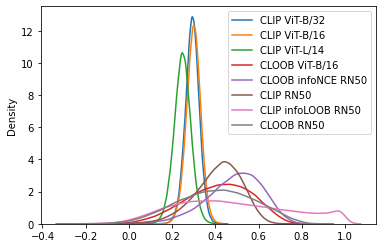

In [23]:
for embeds, name in [(clip_vit_b_32, "CLIP ViT-B/32"),
                     (clip_vit_b_16, "CLIP ViT-B/16"),
                     (clip_vit_l_14, "CLIP ViT-L/14"),
                     (cloob_vit_b_16, "CLOOB ViT-B/16"),
                     (ml_jku_cloob_infoNCE, "CLOOB infoNCE RN50"),
                     (ml_jku_clip_rn50, "CLIP RN50"),
                     (ml_jku_clip_infoLOOB, "CLIP infoLOOB RN50"),
                     (ml_jku_cloob_rn50, "CLOOB RN50")]:
    seaborn.kdeplot((embeds["img_embeds"] * embeds["text_embeds"]).sum(axis=-1), label=name)
plt.legend()

In [20]:
def retrieval(img_embeds, text_embeds, subset_n=50000, top_k=5):
    img_embeds = img_embeds[:subset_n].astype(np.float16).astype(np.float32)
    text_embeds = text_embeds[:subset_n].astype(np.float16).astype(np.float32)
    
    n, channels = img_embeds.shape

    img_index = IndexFlatIP(channels)
    img_index.add(img_embeds)
    
    text_index = IndexFlatIP(channels)
    text_index.add(text_embeds)
    
    ground_truth = np.arange(n)
    
    img_dists, img_idxs = img_index.search(text_embeds, top_k)
    text_dists, text_idxs = text_index.search(img_embeds, top_k)
    
    return {"text->img @1": (img_idxs[:, 0] == ground_truth).sum() / n,
            "img->text @1": (text_idxs[:, 0] == ground_truth).sum() / n,
            "text->img @topk": (img_idxs == ground_truth[:, None]).any(1).sum() / n,
            "img->text @topk": (text_idxs == ground_truth[:, None]).any(1).sum() / n}

In [22]:
results = []
for embeds, name in tqdm.tqdm(
                    [(clip_vit_b_32, "CLIP ViT-B/32"),
                     (clip_vit_b_16, "CLIP ViT-B/16"),
                     (clip_vit_l_14, "CLIP ViT-L/14"),
                     (cloob_vit_b_16, "CLOOB ViT-B/16"),
                     (ml_jku_cloob_infoNCE, "CLOOB infoNCE RN50"),
                     (ml_jku_clip_rn50, "CLIP RN50"),
                     (ml_jku_clip_infoLOOB, "CLIP infoLOOB RN50"),
                     (ml_jku_cloob_rn50, "CLOOB RN50")]):
    results.append({**retrieval(**embeds), "name": name})


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [31:40<00:00, 237.54s/it]


In [24]:
import pandas
results = pandas.DataFrame(results)

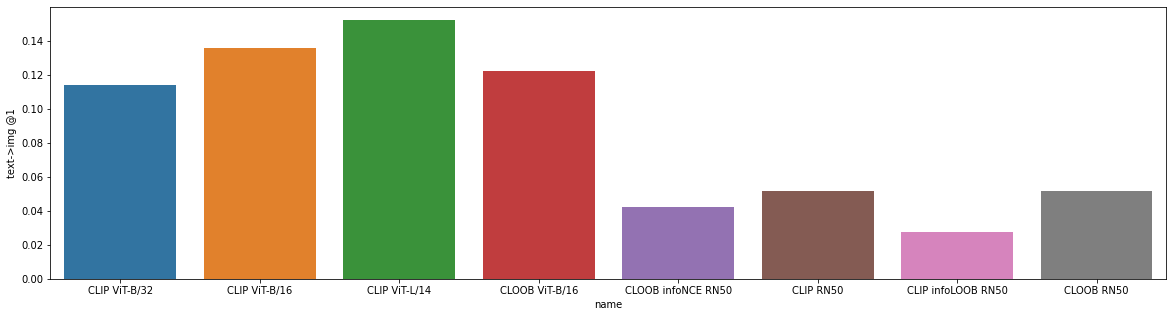

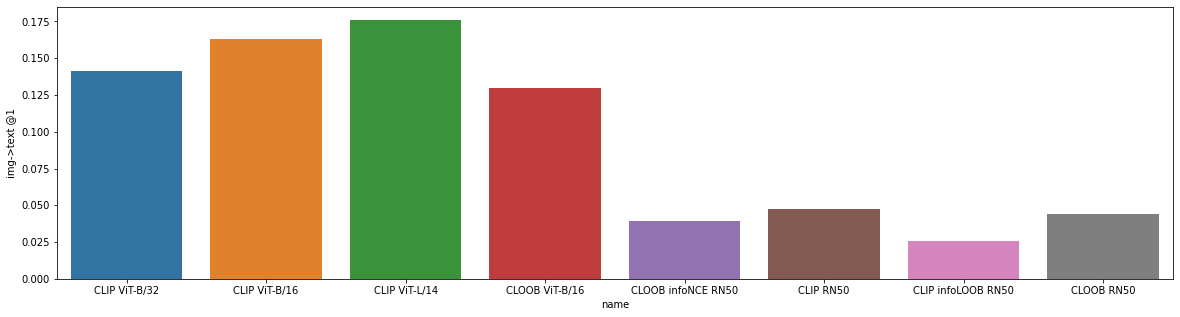

In [31]:
plt.figure(figsize=(20, 5))
seaborn.barplot(data=results, x="name", y="text->img @1")
plt.show()
plt.figure(figsize=(20, 5))
seaborn.barplot(data=results, x="name", y="img->text @1");

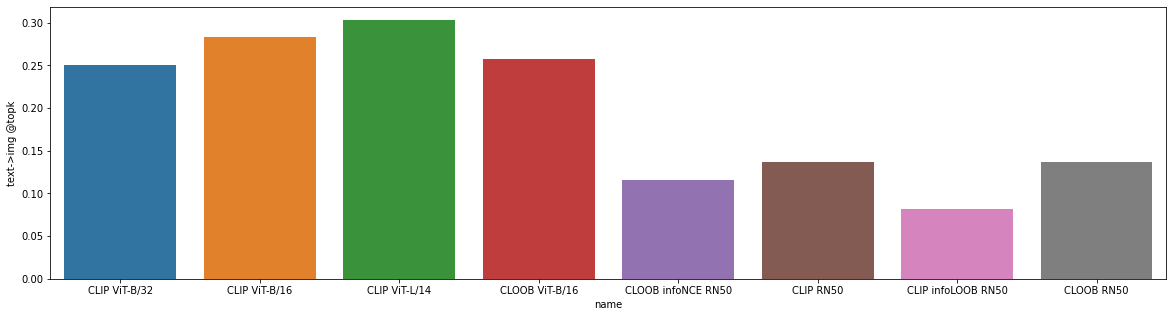

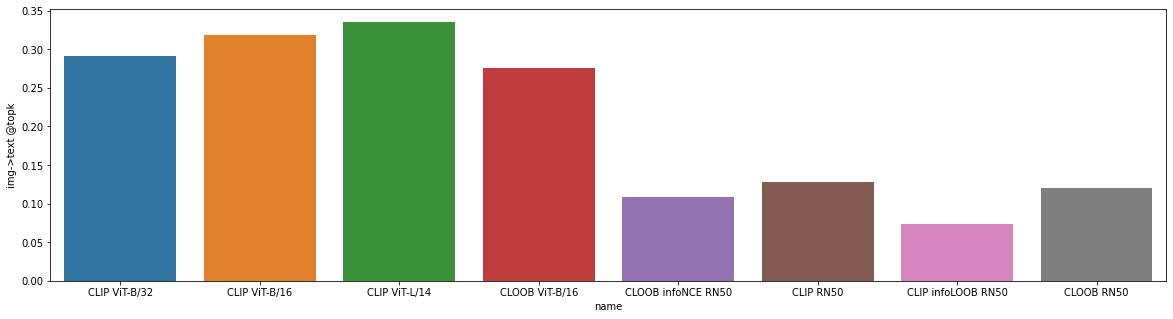

In [33]:
plt.figure(figsize=(20, 5))
seaborn.barplot(data=results, x="name", y="text->img @topk")
plt.show()
plt.figure(figsize=(20, 5))
seaborn.barplot(data=results, x="name", y="img->text @topk");